In [1]:
using Knet: Knet, dir, accuracy, progress, sgd, load, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout
using Statistics
using CUDA
using Random
using LinearAlgebra
using Knet
using Plots; default(fmt=:png,ls=:auto)
using ProgressBars
using NBInclude

In [2]:
if CUDA.functional()
    atype = KnetArray{Float32};
else
    atype = Array{Float32};
end

KnetArray{Float32,N} where N

# Random Deals and Hand Features
Hands are represented with 52-bit vectors and bidding history with 36-bit vectors.

In [3]:
@nbinclude("deal_features.ipynb")

human_readable (generic function with 1 method)

# Deep Q-network Model

In [95]:
@nbinclude("model.ipynb")


database

In [5]:
function initialize_model(;turn_depth=6)
    Q=[]
    Q1=Chain(Dense(52,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    push!(Q,Q1);
    for i in 2:turn_depth
        push!(Q,Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity)));
    end
    return Q
end

initialize_model (generic function with 1 method)

In [6]:
#hyper parameters
epsilon_greedy=0.05;
batch_size=50;


# Hand Reading From txt


Generate a data instance from a PBN-formatted txt 

In [89]:
@nbinclude("hand_reading.ipynb")
averaging_size=5;
files=["all_deals.txt"]
deal_data=[];
for f in files
    file= open(f,"r");
    lines=readlines(file);
    for i in 1:Int(length(lines)/5)
        deal=lines[i*averaging_size];
        north=PBN_to_vector(deal[18:33]);
        south=PBN_to_vector(deal[52:67]);
        cost_list=[]
        for j in 1:averaging_size
            deal=lines[(i-1)*averaging_size+j];
            push!(cost_list,deal[69:end])
        end
        costs=PBN_to_cost(cost_list)
        if costs[1]!=0
            push!(deal_data,(north,south,costs))
        end
    end
end
l=20000
training_set=deal_data[1:l];
test_set=deal_data[l+1:end];


# Main Learning Algorithm

In [90]:
@nbinclude("target_determine.ipynb")
@nbinclude("explore.ipynb")
@nbinclude("bid_functions.ipynb")

sample_bid (generic function with 1 method)

In [91]:
function model_accuracy(models,test_set;progress=false)
    accuracies=[]
    ave_imps=[]
    for Q in models
        got_it=0;
        ave_imp=0
        if progress
            iterator= ProgressBar(test_set)
        else
            iterator= test_set
        end
        for deal in iterator
            _,_,bidding_hist,_,targets=bid(Q,deal)
            true_costs=targets[end]
            if true_costs[findlast(x->x==1,bidding_hist)] == 0
                got_it += 1
            else
                ave_imp += true_costs[findlast(x->x==1,bidding_hist)]*24
            end
        end
        println(got_it/length(test_set))
        println(ave_imp/length(test_set))
        push!(accuracies,got_it/length(test_set))
        push!(ave_imps,ave_imp/length(test_set))
    end
    if length(accuracies)==1
        return accuracies[1],ave_imps[1]
    end
    return accuracies,ave_imps
end

model_accuracy (generic function with 1 method)

In [98]:
function my_train!(Q,training_set,test_set;epochs=1000,progress=true,epsilon_greedy=0.05, batchsize=50,turn_depth=6)
    accuracies=[]
    ave_imp_loss=[]
    accuracies_test=[]
    ave_imp_loss_test=[]
    if progress
        iterator= ProgressBar(1:epochs)
    else
        iterator= 1:epochs;
    end
    for i in iterator
        got_it=0
        ave_imp=0
        database_target_training=database(turn_depth).data
        database_state_training=database(turn_depth).data
        for j in 1:length(training_set)
            bid!(Q,training_set[j],database_state_training,database_target_training,epsilon_greedy);
        end

        accuracy,ave_imp=model_accuracy([Q],training_set);
        push!(accuracies,accuracy);
        push!(ave_imp_loss,ave_imp);
        
        accuracy,ave_imp=model_accuracy([Q],test_set);
        push!(accuracies_test,accuracy);
        push!(ave_imp_loss_test,ave_imp);
        #Experience Replay
        for t in 1:turn_depth
            data=minibatch(hcat(database_state_training[t]...),hcat(database_target_training[t]...),batch_size,shuffle=true);
            if summary(data)[1]=='0'#if no minibatch
            else
                Knet.rmsprop!(Q[t],data);
            end
        end
    end
    return accuracies, ave_imp_loss, accuracies_test,ave_imp_loss_test
end

    

my_train! (generic function with 2 methods)

In [11]:
models=[]
push!(models,get_saved_model("models_1.jld2"));
push!(models,get_saved_model("models_2.jld2"));
push!(models,get_saved_model("models_3.jld2"));

In [81]:
accuracies,ave_imps=model_accuracy(models,training_set)

LoadError: UndefVarError: models not defined

In [99]:
Q=initialize_model()
accuracies, ave_imp_loss, accuracies_test,ave_imp_loss_test=my_train!(Q,training_set,test_set,epochs=10,progress=true);
#Knet.save("models_1.jld2","q_network1", Q[1],"q_network2", Q[2],"q_network3", 
  #  Q[3],"q_network4", Q[4],"q_network5", Q[5],"q_network6", Q[6])

100.0%┣█████████████████████████████████┫ 20000/20000 [00:11<00:00, 1809.8 it/s]
0.00785
9.621888000000208
100.0%┣█████████████████████████████████┫ 54783/54783 [00:30<00:00, 1848.8 it/s]
0.007703119580891883
9.645526531952939
100.0%┣█████████████████████████████████┫ 20000/20000 [00:10<00:00, 2012.4 it/s]
0.2519
4.088447999999848
100.0%┣█████████████████████████████████┫ 54783/54783 [00:23<00:00, 2379.1 it/s]
0.24529507328915903
4.155846886808248
100.0%┣█████████████████████████████████┫ 20000/20000 [00:06<00:00, 3080.7 it/s]
0.18175
4.277711999999751
100.0%┣█████████████████████████████████┫ 54783/54783 [00:19<00:00, 2865.6 it/s]
0.17255352937955204
4.353619188435087
100.0%┣█████████████████████████████████┫ 20000/20000 [00:06<00:00, 3214.5 it/s]
0.2519
3.730991999999744
100.0%┣█████████████████████████████████┫ 54783/54783 [00:16<00:00, 3456.7 it/s]
0.24754029534709673
3.797557636493575
100.0%┣█████████████████████████████████┫ 20000/20000 [00:07<00:00, 2995.3 it/s]
0.3637
3.3607199

Excessive output truncated after 524288 bytes.

93.5%

In [66]:
model_accuracy([Q],training_set)

100.0%┣█████████████████████████████████┫ 10000/10000 [00:05<00:00, 2060.8 it/s]
0.3334
3.260255999999841


(Any[0.3334], Any[3.260255999999841])

In [33]:
sample_bid(Q,training_set[rand(1:end)])


0.002393991
0.0029914926
0.0060811574
0.0039366577
0.0036233822
Any["KJ", "JT4", "Q4", "J85432"]
Any["A", "A965", "AKJ986", "Q6"]
1C
1D
2D
3N


# Plot the Progression at every Epoch

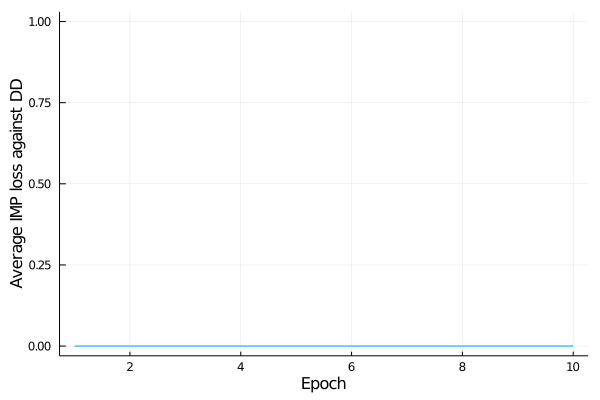

In [103]:
plot(ave_imp_loss,xlabel="Epoch",ylabel="Average IMP loss against DD",label="")


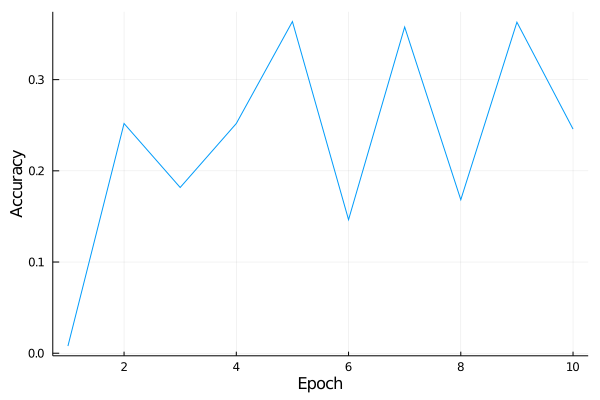

In [104]:
plot(accuracies,xlabel="Epoch",ylabel="Accuracy",label="")


In [ ]:
# Comparison to MLP shows faster convergence, better generalization
plot(test_losses[1],label="Test 1",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[1],label="Train 1",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[2],label="Test 2",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[2],label="Train 2",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[3],label="Test 3",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[3],label="Train 3",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[4],label="Test 4",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[4],label="Train 4",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[5],label="Test 5",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[5],label="Train 5",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[6],label="Test 6",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[6],label="Train 6",xlabel="Epochs",ylabel="Loss",ylims=(0, 0.5))